In [2]:
import torch
import torch.nn as nn
import numpy as np
import scipy as sp

In [3]:
device = "cuda:0"
data = torch.load("/data/lliu/huffman/test/weights_hessian.pt")
data.keys()


W = data["weights"].to(device)
H = data["hessian"].to(device)
del data

In [4]:
# W = torch.randn((4096,14336))

In [5]:
#config

N_qubits = 3
N_gates = int(sp.special.comb(N_qubits, 2))
d_out, d_in = W.shape

from sympy import factorint

def get_qubit_dimensions(d, N_qubits):

    #we assume that d is some power of 2 times 



    factors_raw = factorint(d)
    factors = []
    for k, v in factors_raw.items():
        factors += [k]*v
    factors = sorted(factors, reverse=True)
    # print(factors)
    dimensions = [1]*N_qubits
    i1= 0
    i2 = len(factors)-1
    
    i = 0
    while i1 <= i2:
        if i % (N_qubits*2) < N_qubits:
            dimensions[i % N_qubits] *= factors[i]
            i1 += 1
        else:
            dimensions[i % N_qubits] *= factors[i]
            i2 -= 1
        i += 1
    # print(dimensions)
    assert np.prod(dimensions) == d
    return dimensions

if d_in > d_out:
    layer_type = "compress"
    qubit_dimensions = get_qubit_dimensions(d_out, N_qubits)
    k_factor = int(d_in/(np.prod(qubit_dimensions[1:]))) 
    assert d_in == k_factor*np.prod(qubit_dimensions[1:])
elif d_in < d_out:
    layer_type = "expand"
    qubit_dimensions = get_qubit_dimensions(d_in, N_qubits)
    k_factor = int(d_out/(np.prod(qubit_dimensions[1:]))) 
    assert d_out == k_factor*np.prod(qubit_dimensions[1:])
else:
    layer_type = "square"
    qubit_dimensions = get_qubit_dimensions(d_in, N_qubits)
    k_factor = 1


print(qubit_dimensions, k_factor, layer_type)
# qubit_dimensions = [2**int(np.log2(d**(1/N_qubits)))]*N_qubits
# print(qubit_dimensions)
# print(d/np.prod(qubit_dimensions))
# qubit_dimensions[0] *= int(d/np.prod(qubit_dimensions))
# assert np.prod(qubit_dimensions) == d
# print(qubit_dimensions)

[16, 16, 16] 1 square


In [6]:
import itertools
import opt_einsum as oe
def quanta_apply_einsum_expr(N):
    current_symbols_inds = list(range(N))
    expr = "..."
    for i in current_symbols_inds:
        expr += oe.get_symbol(i)
    for (dim1, dim2) in itertools.combinations(range(-1, -N-1, -1), 2):
        symbol_ind1 = current_symbols_inds[dim1]
        symbol_ind2 = current_symbols_inds[dim2]
        symbol_ind3 = symbol_ind1 + N
        symbol_ind4 = symbol_ind2 + N
        expr += "," + \
            oe.get_symbol(symbol_ind4) + \
            oe.get_symbol(symbol_ind3) + \
            oe.get_symbol(symbol_ind2) + \
            oe.get_symbol(symbol_ind1)
        current_symbols_inds[dim1] = symbol_ind3
        current_symbols_inds[dim2] = symbol_ind4
    expr += "->..."
    for i in current_symbols_inds:
        expr += oe.get_symbol(i)
    return expr

def quanta_op_einsum_expr(N):
    apply_expression = quanta_apply_einsum_expr(N)
    initial_term = apply_expression.split(",")[0].split("...")[-1]
    final_term = apply_expression.split("->")[-1].split("...")[-1]
    middle_terms = apply_expression[apply_expression.find(",")+1:apply_expression.find("->")]
    return f"{middle_terms}->{final_term}{initial_term}"   

quanta_apply_einsum_expr(3)

'...abc,efbc,diaf,ghde->...ghi'

In [7]:
einsum_expr = quanta_op_einsum_expr(N_qubits)
print(einsum_expr)

efbc,diaf,ghde->ghiabc


In [8]:
norm_0 = torch.linalg.norm(W,dim = 0)
W_normalized = W/norm_0.unsqueeze(0)

norm_1 = torch.linalg.norm(W_normalized,dim = 1)
W_normalized = W_normalized/norm_1.unsqueeze(1)

In [9]:
def initialize_gates(N,qubit_dimensions, layer_type, k_factor, W):
    gates = []
    i = len(qubit_dimensions)
    for (dim2,dim1, ) in itertools.combinations(range(-1, -N-1, -1), 2):
        if dim1 == -N and dim2 == -1 and layer_type == "compress":
            new_gate = torch.randn(qubit_dimensions[dim1], qubit_dimensions[dim2], k_factor, qubit_dimensions[dim2]).to(device) * \
                torch.mean(torch.abs(W))**(1/N)/(qubit_dimensions[dim1]*qubit_dimensions[dim2]*k_factor*qubit_dimensions[dim2])**0.25
        elif dim1 == -N and dim2 == -N + 1 and layer_type == "expand":
            new_gate = torch.randn(k_factor, qubit_dimensions[dim2], qubit_dimensions[dim1], qubit_dimensions[dim1]).to(device) * \
                torch.mean(torch.abs(W))**(1/N)/(qubit_dimensions[dim1]*qubit_dimensions[dim2]*k_factor*qubit_dimensions[dim1])**0.25
        
        else:
            new_gate = torch.randn(qubit_dimensions[dim1], qubit_dimensions[dim2], qubit_dimensions[dim1], qubit_dimensions[dim2]).to(device) * \
                    torch.mean(torch.abs(W))**(1/N)/np.sqrt(qubit_dimensions[dim1]*qubit_dimensions[dim2])
        gates.append(new_gate)
        print(f"gate {i} {new_gate.shape}, {dim1}, {dim2}")
        i -=1
    return gates

torch.random.manual_seed(0)
torch.cuda.manual_seed(0)
gates = initialize_gates(N_qubits, qubit_dimensions, layer_type, k_factor, W)

n_params = sum([gate.numel() for gate in gates])    
print(f"{n_params} reduction: {round(n_params/W.numel()*100, 2)}%, bpv {n_params*16/W.numel()}")
      

gate 3 torch.Size([16, 16, 16, 16]), -2, -1
gate 2 torch.Size([16, 16, 16, 16]), -3, -1
gate 1 torch.Size([16, 16, 16, 16]), -3, -2
196608 reduction: 1.17%, bpv 0.1875


In [10]:
layer_type

'square'

In [11]:
quanta_apply_einsum_expr(N_qubits)

'...abc,efbc,diaf,ghde->...ghi'

In [12]:
einsum_expr

'efbc,diaf,ghde->ghiabc'

In [13]:
print([gate.shape for gate in gates])

[torch.Size([16, 16, 16, 16]), torch.Size([16, 16, 16, 16]), torch.Size([16, 16, 16, 16])]


In [14]:
torch.einsum(einsum_expr, *gates).shape

torch.Size([16, 16, 16, 16, 16, 16])

In [15]:
torch.einsum(einsum_expr, *gates).reshape(W.shape)

tensor([[-1.5607e-04, -1.6371e-04,  3.5334e-05,  ...,  5.0662e-05,
          9.9145e-05,  4.0820e-05],
        [-2.7871e-06,  8.6832e-05,  1.2173e-04,  ...,  4.9204e-05,
         -2.3000e-05,  1.8864e-05],
        [-5.8679e-06, -1.3685e-04, -4.1683e-05,  ..., -2.3557e-05,
         -1.6948e-05,  1.4832e-04],
        ...,
        [-6.3560e-05,  5.2123e-05, -1.1675e-04,  ...,  1.1046e-04,
         -1.4163e-07,  4.5130e-05],
        [-3.0893e-05,  1.7756e-04, -9.4706e-05,  ..., -3.1393e-05,
          1.2467e-05, -7.9110e-05],
        [-9.9574e-05, -3.4550e-05, -2.1916e-04,  ...,  1.2618e-04,
         -2.4452e-04, -4.1142e-05]], device='cuda:0')

In [16]:
norm_0 = nn.Parameter(norm_0, requires_grad = False)
norm_1 = nn.Parameter(norm_1, requires_grad = False)

In [17]:
keep_top = 0.00
if keep_top > 0:
    
    threshold = torch.quantile(torch.concat([norm_0, norm_1]), 1-keep_top)
    print(threshold)

    mask_0 = norm_0 > threshold
    mask_1 = norm_1 > threshold


    W_sparse_0 = W_normalized[:,mask_0]
    W_sparse_1 = W_normalized[mask_1,:]

    print((W_sparse_0.numel() + W_sparse_1.numel())/W.numel()*16)

    W_sparse_0 = nn.Parameter(W_sparse_0, requires_grad = True)
    W_sparse_1 = nn.Parameter(W_sparse_1, requires_grad = True)

else:

    mask_0 = torch.zeros_like(norm_0, dtype = torch.bool)
    mask_1 = torch.zeros_like(norm_1, dtype = torch.bool)

In [18]:
total_parameters = sum([gate.numel() for gate in gates]) + norm_0.numel() + norm_1.numel() + ((W_sparse_0.numel() + W_sparse_1.numel()) if keep_top > 0 else 0)
print(total_parameters*16/W.numel())

0.1953125


iter 0, average_error 1.0000265836715698, H_error 5312.076171875, lr 0.01
iter 100, average_error 1.8040425777435303, H_error 21.460651397705078, lr 0.01
iter 200, average_error 1.6660512685775757, H_error 13.505017280578613, lr 0.01
iter 300, average_error 1.5730483531951904, H_error 11.725496292114258, lr 0.01
iter 400, average_error 1.522792100906372, H_error 10.231886863708496, lr 0.01
iter 500, average_error 1.4972412586212158, H_error 9.210708618164062, lr 0.01
iter 600, average_error 1.4829257726669312, H_error 15.025548934936523, lr 0.01
iter 700, average_error 1.475117802619934, H_error 8.436769485473633, lr 0.01
iter 800, average_error 1.4583978652954102, H_error 8.238386154174805, lr 0.01
iter 900, average_error 1.4478546380996704, H_error 6.850631237030029, lr 0.003333333333333333
iter 1000, average_error 1.4392722845077515, H_error 6.0877909660339355, lr 0.001111111111111111
iter 1100, average_error 1.4306544065475464, H_error 5.775102138519287, lr 0.001111111111111111
ite

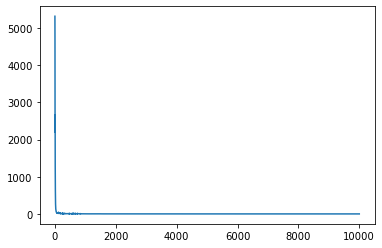

In [ ]:
gates = [nn.Parameter(gate) for gate in gates]
parameters = nn.ParameterList([norm_0, norm_1] + gates + ([W_sparse_0, W_sparse_1] if torch.any(mask_0) or torch.any(mask_1) else []))
optimizer = torch.optim.Adam(gates
                             , lr=1e-2)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1/3, 1.0, 10000)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       factor = 1/3,
                                                       patience = 100)
n_iters = 10000
losses = []
clip_grad = 0.1
for i in range(n_iters):
    reconstructed_W = torch.einsum(einsum_expr, *gates).reshape(W.shape)
    reconstructed_W *= norm_0.unsqueeze(0)
    reconstructed_W *= norm_1.unsqueeze(1)
    if torch.any(mask_0) or torch.any(mask_1):
        reconstructed_W[:,mask_0] += W_sparse_0
        reconstructed_W[mask_1,:] += W_sparse_1
    diff = W - reconstructed_W

    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(W)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    
    optimizer.zero_grad()
    H_error.backward()
    #clip the grad
    torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
    optimizer.step()
    scheduler.step(H_error)
    
    if i % 100 == 0:
        print(f"iter {i}, average_error {average_error}, H_error {H_error}, lr {optimizer.param_groups[0]['lr']}")
    
    losses.append(H_error.item())
    
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [20]:
import torch.nn.functional as F
import time

standard_times = []
einsum_times = []

reconstructed_W = torch.einsum(einsum_expr, *gates).reshape(W.shape)
reconstructed_W *= norm_0.unsqueeze(0)
# reconstructed_W *= norm_1.unsqueeze(1)
# reconstructed_W = torch.einsum(einsum_expr, *gates).reshape(W.shape)

with torch.no_grad():
    for i in range(100):
        x = torch.randn((1000,d_in)).to(device)
        x_reshaped = (x * norm_0.unsqueeze(0)).reshape([1000] + (qubit_dimensions if layer_type !=  "compress" else [k_factor] + qubit_dimensions[1:]))
        
        start = time.time()
        x_try = x @ reconstructed_W.T
        
        # F.linear(x, reconstructed_W)
        standard_times.append(time.time()-start)
        
        start = time.time()
        x_try2 = torch.einsum(quanta_apply_einsum_expr(N_qubits), x_reshaped, *gates).reshape(x.shape[:-1] + (d_out,)) #* norm_1.unsqueeze(0)
        einsum_times.append(time.time()-start)
        break

In [73]:
x_try2

tensor([[-0.4908,  0.6062, -1.4110,  ..., -0.3367,  0.1120,  0.5138],
        [ 0.2419,  0.0143,  0.1184,  ..., -0.1812, -0.1033,  0.9553],
        [-0.3329, -0.4994,  0.1030,  ...,  1.4877, -0.2371,  0.3535],
        ...,
        [ 0.6203, -0.5879,  1.7957,  ..., -0.5400,  0.6840, -1.4585],
        [-0.4578,  1.6304,  0.3078,  ...,  0.0738,  0.3206, -0.6771],
        [ 0.5914, -0.9025,  0.7389,  ...,  0.8147, -0.9273,  0.3088]],
       device='cuda:0')

In [74]:
x_try

tensor([[-0.4908,  0.6062, -1.4110,  ..., -0.3367,  0.1120,  0.5138],
        [ 0.2419,  0.0143,  0.1184,  ..., -0.1812, -0.1033,  0.9553],
        [-0.3329, -0.4994,  0.1030,  ...,  1.4877, -0.2371,  0.3535],
        ...,
        [ 0.6203, -0.5879,  1.7957,  ..., -0.5400,  0.6840, -1.4585],
        [-0.4578,  1.6304,  0.3078,  ...,  0.0738,  0.3206, -0.6771],
        [ 0.5914, -0.9025,  0.7389,  ...,  0.8147, -0.9273,  0.3088]],
       device='cuda:0')

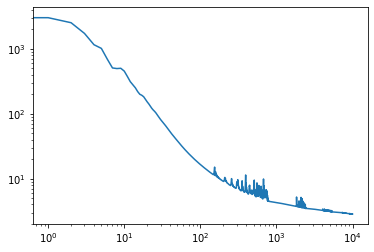

In [136]:
plt.plot(losses)
plt.yscale("log")
plt.xscale("log")
plt.show()

In [45]:
np.min(losses)

3.930149793624878